### Analisis de Localidad

In [8]:
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen
import rasterio
from rasterio.features import shapes


In [2]:
amenazas = gpd.read_file("../data/processed/amenazas/amenaza_valdivia.shp")

In [3]:
w = Queen.from_dataframe(amenazas)
moran = Moran(amenazas["gridcode"], w)

C:\Users\Carloto\AppData\Local\Temp\ipykernel_26548\1739040107.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(amenazas)
C:\Users\Carloto\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 58417.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 58417, ' is an island (no neighbors)')


In [5]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.245773610545895, p-value: 0.001


In [6]:
src = rasterio.open("../data/processed/vegetacion_processed.tif")

In [9]:
resultados_formas = shapes(src.read(1), transform=src.transform)

# Crear GeoDataFrame
vegetacion = gpd.GeoDataFrame.from_features(
    [{'geometry': geom, 'properties': {'ndvi': val}} for geom, val in resultados_formas],
    crs=src.crs
)

In [10]:
w = Queen.from_dataframe(vegetacion)
moran = Moran(vegetacion["ndvi"], w)

C:\Users\Carloto\AppData\Local\Temp\ipykernel_26548\2546796185.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(vegetacion)


In [11]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.9077192790247994, p-value: 0.001


In [12]:
src = rasterio.open("../data/processed/topologia_processed.tif")

resultados_formas = shapes(src.read(1), transform=src.transform)

# Crear GeoDataFrame
topologia = gpd.GeoDataFrame.from_features(
    [{'geometry': geom, 'properties': {'altura': val}} for geom, val in resultados_formas],
    crs=src.crs
)

In [13]:
w = Queen.from_dataframe(topologia)
moran = Moran(topologia["altura"], w)

C:\Users\Carloto\AppData\Local\Temp\ipykernel_26548\2604982556.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(topologia)


In [14]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.9980011465206547, p-value: 0.001


#### Correlación entre variables

In [15]:
datos = amenazas.sjoin(vegetacion.to_crs(amenazas.crs))

In [16]:
datos

,Id,gridcode,geometry,index_right,ndvi
0,941693,2,"MULTIPOLYGON (((-73.24841 -39.90579, -73.24829...",998404,0.1229
0,941693,2,"MULTIPOLYGON (((-73.24841 -39.90579, -73.24829...",942329,0.1242
0,941693,2,"MULTIPOLYGON (((-73.24841 -39.90579, -73.24829...",941506,0.1216
0,941693,2,"MULTIPOLYGON (((-73.24841 -39.90579, -73.24829...",941138,0.1226
0,941693,2,"MULTIPOLYGON (((-73.24841 -39.90579, -73.24829...",942327,0.1192
...,...,...,...,...,...
86738,538244,0,"MULTIPOLYGON (((-73.40311 -39.86939, -73.40311...",1515,0.1476
86738,538244,0,"MULTIPOLYGON (((-73.40311 -39.86939, -73.40311...",1516,0.1468
86738,538244,0,"MULTIPOLYGON (((-73.40311 -39.86939, -73.40311...",304,0.1426
86738,538244,0,"MULTIPOLYGON (((-73.40311 -39.86939, -73.40311...",305,0.1438


### Simulación

In [17]:
import moderngl
import numpy as np
import matplotlib.pyplot as plt

# Crea el contexto y el compute shader
ctx = moderngl.create_context(standalone=True)

compute = ctx.compute_shader(open("../src/shader/simular.glsl").read())

# Estados iniciales
estados = np.zeros((32, 32), dtype=np.int32)
estados[16, 0] = 1

# Genera los buffers para la simulación
buf_a = ctx.buffer(estados.tobytes())
buf_a.bind_to_storage_buffer(0)
buf_b = ctx.buffer(estados.tobytes())
buf_b.bind_to_storage_buffer(1)

def inicializar():
    global buf_a, buf_b
    estados = np.zeros((32, 32), dtype=np.int32)
    estados[16, 0] = 1
    buf_a = ctx.buffer(estados.tobytes())
    buf_a.bind_to_storage_buffer(0)
    buf_b = ctx.buffer(estados.tobytes())
    buf_b.bind_to_storage_buffer(1)

# Ejecuta un paso en la simulación
def paso():
    global buf_a, buf_b
    buf_a.bind_to_storage_buffer(0)
    buf_b.bind_to_storage_buffer(1)

    compute.run(group_x=1, group_y=1)
    ctx.memory_barrier(moderngl.SHADER_STORAGE_BARRIER_BIT)
    buf_a, buf_b = buf_b, buf_a

In [19]:
import imageio.v2 as imageio

# Guarda las texturas para mapearlas en la renderización de la simulación
arbol = (imageio.imread("../extra/tree.png")[..., :3]).astype(np.uint8)
fuego = (imageio.imread("../extra/fire.png")[..., :3]).astype(np.uint8)
ceniza = (imageio.imread("../extra/ashes.png")[..., :3]).astype(np.uint8)

texturas = np.array([
    arbol,
    fuego,
    ceniza
])

In [20]:
writer = imageio.get_writer(
    "../outputs/maps/simulacion.mp4",
    fps=2,
    codec="libx264",
    pixelformat="yuv420p"
)

inicializar()

for i in range(50):
    paso()
    estado_incendio = texturas[(np.reshape(np.frombuffer(buf_a.read(), dtype=np.int32), [32, -1]))]

    estado_incendio = np.reshape(
        estado_incendio.transpose(0, 2, 1, 3, 4),
        [32*32, 32*32, 3]
    )
    writer.append_data(estado_incendio)

writer.close()

Iniciando simulación y generación de video...
✅ Video guardado en ../outputs/maps/simulacion.mp4
✅ Datos estadísticos guardados en ../data/processed/stats_simulacion.csv


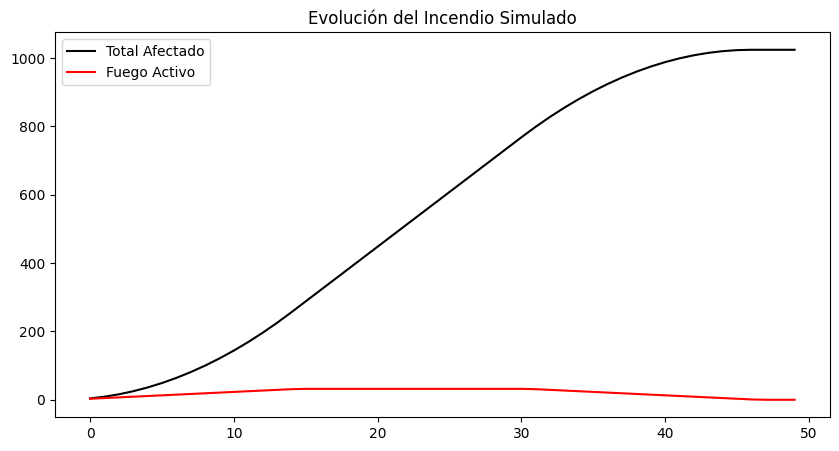

In [23]:
import pandas as pd
import numpy as np
import imageio.v2 as imageio 
writer = imageio.get_writer(
    "../outputs/maps/simulacion.mp4",
    fps=2,
    codec="libx264",
    pixelformat="yuv420p"
)

inicializar()

# Lista para guardar los datos del gráfico
historial_incendio = []

print("Iniciando simulación y generación de video...")

# Asumimos que las texturas son de 32x32 píxeles (basado en tu error)
TILE_SIZE = 32 
GRID_SIZE = 32

for i in range(50):
    paso()
    
    # 1. LEER ESTADO ACTUAL (0=arbol, 1=fuego, 2=ceniza)
    raw_buffer = np.frombuffer(buf_a.read(), dtype=np.int32)
    # Reformamos el buffer a la grilla de simulación (32x32 celdas)
    grid_estado = np.reshape(raw_buffer, (GRID_SIZE, GRID_SIZE))
    
    # 2. GENERAR FRAME PARA VIDEO (Lógica de Tiling/Mosaico)
    # Mapeamos cada celda a su textura correspondiente (Sprite 32x32)
    # Esto crea un array de forma: (32, 32, 32, 32, 3) -> (GridY, GridX, TileY, TileX, RGB)
    mosaico = texturas[grid_estado]
    
    # Reordenamos los ejes para formar la imagen final grande
    # Transponer a: (GridY, TileY, GridX, TileX, RGB)
    mosaico = mosaico.transpose(0, 2, 1, 3, 4)
    
    # Colapsamos dimensiones para tener una imagen 2D grande (1024x1024 px)
    imagen_final = mosaico.reshape(GRID_SIZE * TILE_SIZE, GRID_SIZE * TILE_SIZE, 3)
    
    writer.append_data(imagen_final)
    
    # 3. CALCULAR DATOS PARA EL GRÁFICO
    # Contamos celdas (no píxeles de imagen, sino celdas de simulación)
    celdas_fuego = np.sum(grid_estado == 1)
    celdas_quemadas = np.sum(grid_estado > 1) 
    total_afectado = celdas_fuego + celdas_quemadas
    
    historial_incendio.append({
        "Paso": i,
        "Fuego Activo": celdas_fuego,
        "Area Quemada": total_afectado
    })

writer.close()
print("✅ Video guardado en ../outputs/maps/simulacion.mp4")

# 4. GUARDAR DATOS EN CSV PARA MAIN.PY
df_simulacion = pd.DataFrame(historial_incendio)
# Asegúrate de que la carpeta exista o usa una ruta válida
csv_path = "../data/processed/stats_simulacion.csv"
df_simulacion.to_csv(csv_path, index=False)
print(f"✅ Datos estadísticos guardados en {csv_path}")

# Previsualización rápida
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_simulacion["Paso"], df_simulacion["Area Quemada"], label="Total Afectado", color="black")
plt.plot(df_simulacion["Paso"], df_simulacion["Fuego Activo"], label="Fuego Activo", color="red")
plt.title("Evolución del Incendio Simulado")
plt.legend()
plt.show()